In [1]:
# Step 1: Install & Import Dependencies
!pip install torch matplotlib --quiet

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Step 2: Define the Neural Network

class SineModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 40),
            nn.ReLU(),
            nn.Linear(40, 40),
            nn.ReLU(),
            nn.Linear(40, 1)
        )

    def forward(self, x, weights=None):
        """Forward pass with optional custom weights (for inner loop)."""
        if weights is None:
            return self.net(x)
        else:
            # manual forward pass using adapted weights
            x = torch.relu(torch.matmul(x, weights['0.weight'].T) + weights['0.bias'])
            x = torch.relu(torch.matmul(x, weights['2.weight'].T) + weights['2.bias'])
            x = torch.matmul(x, weights['4.weight'].T) + weights['4.bias']
            return x


In [3]:
# Step 3: Create Sine Wave Tasks

def generate_task():
    """Return a random sine wave function."""
    A = np.random.uniform(0.1, 5.0)
    phase = np.random.uniform(0, np.pi)
    def f(x): return A * np.sin(x + phase)
    return f

def sample_data(f, num_samples=10):
    """Sample x,y pairs from a sine function."""
    x = np.random.uniform(-5, 5, size=(num_samples, 1))
    y = f(x)
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


In [4]:
# Step 4: Meta-Learning (MAML)

model = SineModel()
meta_optimizer = optim.Adam(model.parameters(), lr=0.001)

meta_steps = 1000        # how many meta-iterations
inner_steps = 1          # how many inner updates per task
inner_lr = 0.01          # inner loop learning rate
tasks_per_meta_batch = 4 # number of tasks per meta-update

print("Starting Meta-Training... (this takes ~1-2 min)")

for step in range(meta_steps):
    meta_optimizer.zero_grad()
    meta_loss = 0.0

    for task in range(tasks_per_meta_batch):
        f = generate_task()
        x_train, y_train = sample_data(f, 10)
        x_val, y_val = sample_data(f, 10)

        # compute loss on training samples
        y_pred = model(x_train)
        loss = nn.MSELoss()(y_pred, y_train)
        grads = torch.autograd.grad(loss, model.parameters(), create_graph=True)

        # perform one inner update (fast adaptation)
        fast_weights = {name: param - inner_lr * grad
                        for (name, param), grad in zip(model.net.named_parameters(), grads)}

        # evaluate on validation samples
        y_val_pred = model(x_val, weights=fast_weights)
        val_loss = nn.MSELoss()(y_val_pred, y_val)
        meta_loss += val_loss

    # Outer update: improve the initialization to adapt faster next time
    meta_loss /= tasks_per_meta_batch
    meta_loss.backward()
    meta_optimizer.step()

    if step % 100 == 0:
        print(f"Step {step:04d} | Meta-loss: {meta_loss.item():.4f}")

print("Meta-learning complete!")

Starting Meta-Training... (this takes ~1-2 min)
Step 0000 | Meta-loss: 6.9920
Step 0100 | Meta-loss: 2.3677
Step 0200 | Meta-loss: 4.4285
Step 0300 | Meta-loss: 4.0446
Step 0400 | Meta-loss: 2.6556
Step 0500 | Meta-loss: 0.7661
Step 0600 | Meta-loss: 1.3437
Step 0700 | Meta-loss: 3.0300
Step 0800 | Meta-loss: 3.9927
Step 0900 | Meta-loss: 2.5782
Meta-learning complete!


In [5]:
# Step 5: Test on a NEW Sine Wave (Few-Shot Adaptation)

f_new = generate_task()
x_test, y_test = sample_data(f_new, 10)
x_grid = torch.linspace(-5, 5, 100).reshape(-1, 1)

# Before adaptation
y_pred_before = model(x_grid).detach()

# Fine-tune (inner loop) on only 10 samples
y_pred = model(x_test)
loss = nn.MSELoss()(y_pred, y_test)
grads = torch.autograd.grad(loss, model.parameters())
with torch.no_grad():
    for p, g in zip(model.parameters(), grads):
        p -= inner_lr * g

# After adaptation
y_pred_after = model(x_grid).detach()

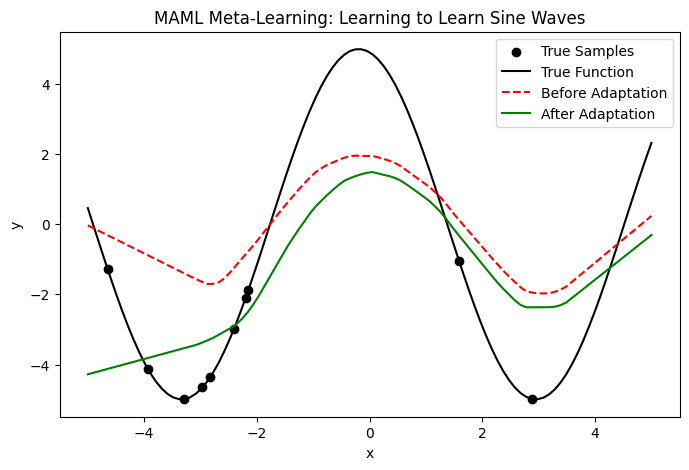

In [6]:
# Step 6: Visualize

plt.figure(figsize=(8,5))
plt.scatter(x_test, y_test, color='black', label='True Samples')
plt.plot(x_grid, f_new(x_grid.numpy()), 'k-', label='True Function')
plt.plot(x_grid, y_pred_before, 'r--', label='Before Adaptation')
plt.plot(x_grid, y_pred_after, 'g-', label='After Adaptation')
plt.legend()
plt.title("MAML Meta-Learning: Learning to Learn Sine Waves")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip3 install nbconvert

In [ ]:
# Convert the notebook to HTML using the full path
!jupyter nbconvert --to html "/content/drive/MyDrive/UEL-Intelligence-System-Lab/MetaLearning.ipynb"
